In [197]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
from itertools import permutations
from itertools import product

In [198]:
with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('./pickles/newResa4.pickle', 'rb') as handle:
    newResa4 = pickle.load(handle)

with open('./pickles/newResa6.pickle', 'rb') as handle:
    newResa6 = pickle.load(handle)

with open('./pickles/kmeans_total_3_c4.pickle', 'rb') as handle:
    kmeans_total3 = pickle.load(handle)

with open('./pickles/kmeans_total_3_c4.pickle', 'rb') as handle:
    kmeans_total3_master = pickle.load(handle)

with open('./pickles/kmeans_total_4_c6.pickle', 'rb') as handle:
    kmeans_total4 = pickle.load(handle)

with open('./pickles/kmeans_total_4_c6.pickle', 'rb') as handle:
    kmeans_total4_master = pickle.load(handle)

with open('./pickles/kmeans_total_6_c2.pickle', 'rb') as handle:
    kmeans_total6 = pickle.load(handle)

with open('./pickles/kmeans_total_6_c2.pickle', 'rb') as handle:
    kmeans_total6_master = pickle.load(handle)

In [199]:
num_classi = 5

newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]
newResa4 = newResa4[(newResa4<=11000) & (newResa4 >= 4000)]
newResa6 = newResa6[(newResa6<=11000) & (newResa6 >= 4000)]

In [200]:
def split_resa(k,resa):
    percentile_value = 1/k
    label = np.ndarray([resa.shape[0]],dtype=int)
    label[:] = int(-1)

    for i in range(0,k):
        label[(resa <= np.quantile(resa,q=(percentile_value*(i+1)))) & (resa >= np.quantile(resa,q=(percentile_value*i)))] = i

    return label


In [201]:
def removeTexts(xlim=np.Inf,ylim=np.Inf):
    axis = plt.gca()
    for text in axis.texts:
        if text.get_position()[0] > xlim or text.get_position()[0] > ylim: #check if x is more than 3
            text.remove()


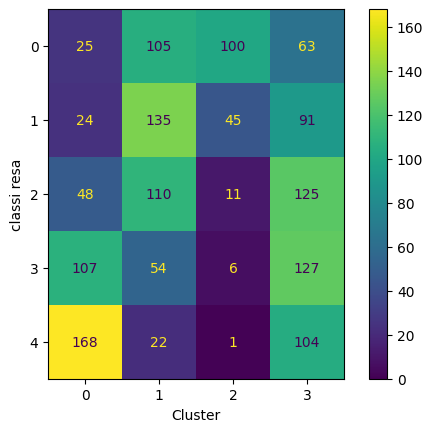

In [202]:
label = split_resa(num_classi,newResa3)

ConfusionMatrixDisplay.from_predictions(label,kmeans_total3[6,0])

removeTexts(xlim=3)
plt.xlabel('Cluster')
plt.ylabel('classi resa')
plt.xlim([-0.5,3.5])
plt.show()

In [203]:
print(list(product(np.unique(label),repeat=len(np.unique(kmeans_total3[6,0])))))
print(np.unique(label))
print(len(np.unique(kmeans_total3[6,0])))

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 0, 4), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 1, 4), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 2, 4), (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3), (0, 0, 3, 4), (0, 0, 4, 0), (0, 0, 4, 1), (0, 0, 4, 2), (0, 0, 4, 3), (0, 0, 4, 4), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 0, 3), (0, 1, 0, 4), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 1, 2), (0, 1, 1, 3), (0, 1, 1, 4), (0, 1, 2, 0), (0, 1, 2, 1), (0, 1, 2, 2), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 0), (0, 1, 3, 1), (0, 1, 3, 2), (0, 1, 3, 3), (0, 1, 3, 4), (0, 1, 4, 0), (0, 1, 4, 1), (0, 1, 4, 2), (0, 1, 4, 3), (0, 1, 4, 4), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 0, 2), (0, 2, 0, 3), (0, 2, 0, 4), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 1, 2), (0, 2, 1, 3), (0, 2, 1, 4), (0, 2, 2, 0), (0, 2, 2, 1), (0, 2, 2, 2), (0, 2, 2, 3), (0, 2, 2, 4), (0, 2, 3, 0), (0, 2, 3, 1), (0, 2, 3, 2), (0, 2, 3, 3), (0, 2, 3, 4), (0, 2, 4, 0), (0, 2

In [204]:
def best_cluster(matrice,cluster):
    a = np.arange(matrice.shape[0])
    permutation = list(product(np.unique(label),repeat=len(np.unique(cluster))))
    obiettivo = {'max': 0,
                'perm':[]}

    for perm in permutation:
        somma = 0
        for elem,index in zip(perm,range(matrice.shape[0])):
            somma += matrice[index,elem]
        if(somma > obiettivo['max']):
            obiettivo['max'] = somma
            obiettivo['perm'] = perm

    test_map = {}
    for pippo,pluto in zip(obiettivo['perm'],range(matrice.shape[0])):
        test_map[pluto] = pippo
    return test_map


In [205]:
cluster_class_mapping = {}
matrice_elementi = np.ndarray((len(np.unique(kmeans_total3[6,0])),num_classi))

for kmean in range(0,len(np.unique(kmeans_total3[6,0]))):

    cluster_classes = label[kmeans_total3[6,0] == kmean]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    
    matrice_elementi[kmean,:] = class_counts
    
cluster_class_mapping = best_cluster(matrice_elementi,kmeans_total3[6,0])

In [206]:
print(np.unique(kmeans_total3[6,0],return_counts=True))
print(cluster_class_mapping)

(array([0, 1, 2, 3], dtype=int64), array([372, 426, 163, 510], dtype=int64))
{0: 4, 1: 1, 2: 0, 3: 3}


In [207]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])
for i in range(len(np.unique(kmeans_total3[6,0]))):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [208]:
print(difference)

  num_cluster num_class
0           0         4
1           2         0


In [209]:
indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(kmeans_total3[6,0]))
    if kmeans_total3[6,0][index] == a
])
for ind,true_value in zip(indici,difference['num_class']):
    kmeans_total3[6,0][ind] = true_value

In [210]:
cluster_class_mapping_test = {}
matrice_elementi = np.ndarray((len(np.unique(kmeans_total3[6,0])),num_classi))

for kmean in range(0,len(np.unique(kmeans_total3[6,0]))):

    cluster_classes = label[kmeans_total3[6,0] == kmean]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    
    matrice_elementi[kmean,:] = class_counts
    
cluster_class_mapping_test = best_cluster(matrice_elementi,kmeans_total3[6,0])

ValueError: could not broadcast input array from shape (0,) into shape (5,)

In [ ]:
print(cluster_class_mapping_test)

{0: 0, 1: 1, 2: 2, 3: 3}


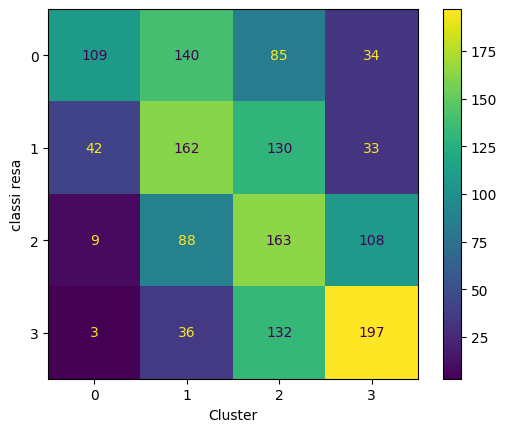

In [ ]:
ConfusionMatrixDisplay.from_predictions(label,kmeans_total3[6,0])

removeTexts(xlim=3)
plt.xlabel('Cluster')
plt.ylabel('classi resa')
plt.show()

In [ ]:
accuracy = str(accuracy_score(label,kmeans_total3[6,0]))
precision = str(precision_score(label,kmeans_total3[6,0],average= 'macro'))
recall = str(recall_score(label,kmeans_total3[6,0],average= 'macro'))

print("accuratezza " + accuracy)
print("precision " + precision)
print("recall " + recall)

accuratezza 0.42895989123045547
precision 0.474542770548234
recall 0.4289683538680251
